In [1]:
import sys
import os
import math
import numpy as np
import pandas
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
sys.path.insert(0, "../../python")
from common import *

In [2]:
input_path = '../../../../output/tuples-v2-training-v2-t1/testing/'
deep_results = '../../../../output/predictions/2017v2p6/step1_e6/'
input_files = { 'e': 'e_DY.h5', 'mu': 'mu_DY.h5', 'tau': 'tau_HTT.h5', 'jet': 'jet_QCD.h5' }

In [3]:
core_branches = [ 'tau_pt', 'tau_eta', 'tau_phi', 'tau_decayMode' ]
all_branches = core_branches
    
def ReadBrancesToDataFrame(file_name, tree_name, branches):
    if file_name.endswith('.root'):
        with uproot.open(file_name) as file:
            tree = file[tree_name]
            df = tree.arrays(branches, outputtype=pandas.DataFrame)
        return df
    elif file_name.endswith('.h5') or file_name.endswith('.hdf5'):
        return pandas.read_hdf(file_name, tree_name, columns=branches)
    raise RuntimeError("Unsupported file type.")
    
def CreateDF(file_name):
    df = ReadBrancesToDataFrame(input_path + file_name, 'taus', all_branches)
    pred_file_name = os.path.splitext(file_name)[0] + '_pred.h5'
    df_pred = pandas.read_hdf(os.path.join(deep_results, pred_file_name))
    for out in match_suffixes:
        if out != 'tau':
            tau_vs_other = TauLosses.tau_vs_other(df_pred['deepId_tau'].values, df_pred['deepId_' + out].values)
            df['deepId_vs_' + out] = pandas.Series(tau_vs_other, index=df.index)
        df['deepId_' + out] = pandas.Series(df_pred['deepId_' + out].values, index=df.index)
    df['tau_pt'] = pandas.Series(df.tau_pt *(1000 - 20) + 20, index=df.index)
    df['tau_eta'] = pandas.Series(df.tau_eta * 2.3, index=df.index)
    df['tau_phi'] = pandas.Series(df.tau_phi * math.pi, index=df.index)
    return df

In [4]:
all_df = {}
for out in match_suffixes:
    all_df[out] = CreateDF(input_files[out])

In [5]:
def create_roc(all_df, pt_min, pt_max, tpr_step):
    df_sel = {}
    tpr = np.arange(0, 1+tpr_step, tpr_step)
    fpr = {}
    thr = {}
    for tau_type in match_suffixes:
        df = all_df[tau_type]
        df_sel[tau_type] = df[(df.tau_pt > pt_min) & (df.tau_pt < pt_max) & (df.deepId_vs_e > 0.1358319) \
                              & (df.deepId_vs_mu > 0.1509980) ]
    for other_type in ['e', 'mu', 'jet']:
        id_column = 'deepId_vs_' + other_type
        thr[other_type] = np.quantile(df_sel['tau'][id_column], 1 - tpr)
        fpr[other_type] = np.zeros(tpr.shape[0])
        for n in range(tpr.shape[0]):
            fpr[other_type][n] = np.count_nonzero(df_sel[other_type][id_column] > thr[other_type][n]) \
                                 / df_sel[other_type].shape[0]
    return tpr, fpr, thr

In [6]:
tpr, fpr, thr = create_roc(all_df, 30, 70, 0.0001)

In [7]:
def plot_first_derivative(tpr, fpr, min_window=1, relative=False):
    x = []
    y = []
    n = 0
    while n < len(tpr) - min_window:
        k = n + min_window
        while k < len(tpr) and fpr[k] - fpr[n] == 0:
            k += 1
        if k < len(tpr) and fpr[k] - fpr[n] != 0:
            y_val = (fpr[k] - fpr[n]) / (tpr[k] - tpr[n])
            if relative:
                y_val /= (fpr[k] + fpr[n]) / 2
            x.append((tpr[k] + tpr[n]) / 2)
            y.append(y_val)
        n = k
    plt.plot(x, y)

In [8]:
def plot_s_sqrt_b(tpr, fpr, min_window):
    x = []
    y = []
    n = 0
    while n < len(tpr) - min_window:
        k = n + min_window
        s = (tpr[k] + tpr[n]) / 2
        b = (fpr[k] + fpr[n]) / 2
        x.append(s)
        y.append(s/math.sqrt(b))
        n = k
    plt.plot(x, y)

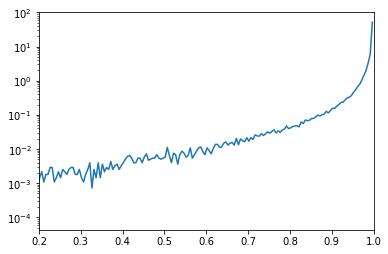

In [9]:
bkg='jet'
plot_first_derivative(tpr, fpr[bkg], 50, False)
plt.xlim([0.2, 1])
plt.yscale('log')

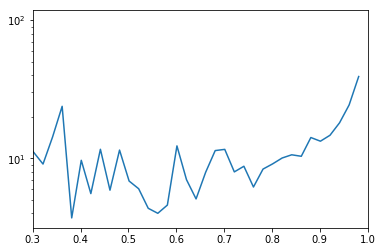

In [10]:
bkg='e'
plot_first_derivative(tpr, fpr[bkg], 200, True)
plt.xlim([0.3, 1])
plt.yscale('log')

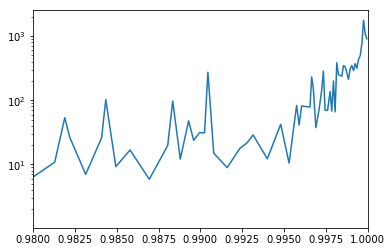

In [11]:
bkg='mu'
plot_first_derivative(tpr, fpr[bkg], 1, True)
plt.xlim([0.98, 1])
plt.yscale('log')

In [12]:
bkg='mu'
am = (((fpr[bkg][1:] - fpr[bkg][0:-1]) /(tpr[1:] - tpr[0:-1]) > 1)).argmax()
am, tpr[am], fpr[bkg][am], thr[bkg][am]

(2181, 0.21810000000000002, 0.0, 0.9999971985816956)

In [13]:
wp_definitions = {
    'e': {
        'wp_names': ["VVTight", "VTight", "Tight", "Medium", "Loose", "VLoose", "VVLoose", "VVVLoose"],
        'wp_eff': [0.6, 0.7, 0.8, 0.9, 0.95, 0.98, 0.99, 0.995],
        'thrs': []
    },
    'mu': {
        'wp_names': ["Tight", "Medium", "Loose", "VLoose"],
        'wp_eff': [0.995, 0.998, 0.999, 0.9995],
        'thrs': []
    },
    'jet': {
        'wp_names': ["VVTight", "VTight", "Tight", "Medium", "Loose", "VLoose", "VVLoose", "VVVLoose"],
        'wp_eff': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98],
        'thrs': []
    }
}

In [14]:
def create_roc(all_df, wp_definitions, pt_min, pt_max, tpr_step):
    #df_sel = {}
    tpr = np.arange(0, 1+tpr_step, tpr_step)
    fpr = {}
    thr = {}
    for tau_type in ['e', 'mu', 'jet']:
        df_sel = {}
        for tau_type_2 in ['tau', tau_type]:
            df = all_df[tau_type_2]
            wp_def = wp_definitions[tau_type]
            sel = (df.tau_pt > pt_min) & (df.tau_pt < pt_max)
            for tau_type_3 in ['e', 'mu', 'jet']:
                if tau_type_3 == tau_type: continue
                wp_def = wp_definitions[tau_type_3]
                thrs = wp_def['thrs']
                if len(thrs) > 0:
                    sel_thr = thrs[-1][-1]
                    sel = sel & (df['deepId_vs_' + tau_type_3] > sel_thr)
            df_sel[tau_type_2] = df[sel]
        id_column = 'deepId_vs_' + tau_type
        thr[tau_type] = np.quantile(df_sel['tau'][id_column], 1 - tpr)
        fpr[tau_type] = np.zeros(tpr.shape[0])
        for n in range(tpr.shape[0]):
            fpr[tau_type][n] = np.count_nonzero(df_sel[tau_type][id_column] > thr[tau_type][n]) \
                                 / df_sel[tau_type].shape[0]
    return tpr, fpr, thr

In [15]:
def calc_thresholds(wp_definitions, tpr, thr):
    for tau_type in ['e', 'mu', 'jet']:
        wp_def = wp_definitions[tau_type]
        wp_eff = wp_def['wp_eff']
        new_thrs = []
        for eff in wp_eff:
            idx = (tpr >= eff).argmax()
            new_thrs.append(thr[tau_type][idx])
        wp_def['thrs'].append(new_thrs)

In [16]:
def print_wp(wp_definitions):
    print("working_points = {")
    for tau_type in ['e', 'mu', 'jet']:
        wp_def = wp_definitions[tau_type]
        wp_names = wp_def['wp_names']
        wp_thrs = wp_def['thrs'][-1]
        print('    "{}": {{'.format(tau_type))
        for n in reversed(range(len(wp_names))):
            name = wp_names[n]
            thr = wp_thrs[n]
            print( '        "{}": {:.7f},'.format(name, thr))
        print('    },')
    print('}')

In [17]:
for i in range(100):
    print("iteration", i)
    tpr, fpr, thr = create_roc(all_df, wp_definitions, 30, 70, 0.0001)
    calc_thresholds(wp_definitions, tpr, thr)
    print_wp(wp_definitions)
    all_converged = True
    for key,value in wp_definitions.items():
        all_converged = all_converged and len(value['thrs']) >= 2 \
            and abs(value['thrs'][-1][-1] - value['thrs'][-2][-1]) < 1e-7
    if all_converged: break

iteration 0
working_points = {
    "e": {
        "VVVLoose": 0.0621387,
        "VVLoose": 0.1358319,
        "VLoose": 0.3187459,
        "Loose": 0.6359438,
        "Medium": 0.8644865,
        "Tight": 0.9628930,
        "VTight": 0.9843626,
        "VVTight": 0.9922436,
    },
    "mu": {
        "VLoose": 0.0974002,
        "Loose": 0.1509980,
        "Medium": 0.2779535,
        "Tight": 0.6286244,
    },
    "jet": {
        "VVVLoose": 0.2585829,
        "VVLoose": 0.4226685,
        "VLoose": 0.5958089,
        "Loose": 0.7827727,
        "Medium": 0.8818980,
        "Tight": 0.9299462,
        "VTight": 0.9568231,
        "VVTight": 0.9731184,
    },
}
iteration 1
working_points = {
    "e": {
        "VVVLoose": 0.0630434,
        "VVLoose": 0.1686154,
        "VLoose": 0.3627847,
        "Loose": 0.6813900,
        "Medium": 0.8846235,
        "Tight": 0.9675193,
        "VTight": 0.9859071,
        "VVTight": 0.9928368,
    },
    "mu": {
        "VLoose": 0.1054134,
    

In [266]:
def efficiency(x, thrs):
    N = x.shape[0]
    eff = np.zeros(thrs.shape[0])
    eff_down = np.zeros(thrs.shape[0])
    eff_up = np.zeros(thrs.shape[0])
    if N != 0:
        for k in range(thrs.shape[0]):
            n = np.count_nonzero(x > thrs[k])
            eff[k] = n/N
            eff_down[k], eff_up[k] = proportion_confint(n, N, 1-0.682689, 'beta')
    return eff, eff_down, eff_up

In [264]:
def diff_efficiency(df_true, df_fake, var_name, var_bins, thrs, discr_name):
    eff = np.zeros([len(var_bins)-1, 2, thrs.shape[0]])
    eff_up = np.zeros(eff.shape)
    eff_down = np.zeros(eff.shape)
    for n in range(0, len(var_bins) - 1):
        x_true = df_true[(df_true[var_name] > var_bins[n]) & (df_true[var_name] <= var_bins[n+1])][discr_name]
        x_fake = df_fake[(df_fake[var_name] > var_bins[n]) & (df_fake[var_name] <= var_bins[n+1])][discr_name]
        eff[n, 0, :], eff_down[n, 0, :], eff_up[n, 0, :] = efficiency(x_true, thrs)
        eff[n, 1, :], eff_down[n, 1, :], eff_up[n, 1, :] = efficiency(x_fake, thrs)
    eff_up = eff_up - eff
    eff_down = eff - eff_down
    return eff, eff_up, eff_down

In [430]:
def draw_diff_eff(eff, eff_up, eff_down, var_bins, thrs, xscale, yscale_1, ylim_1, ylim_2,
                  x_title, y1_title, y2_title, labels, legend_loc, output_file_name, xlabels=None):
    if xlabels is None:
        x = (var_bins[1:]+var_bins[0:-1])/2
        xerr = ((var_bins[1:]-var_bins[0:-1])/2)
    else:
        x = range(len(xlabels))
        xerr = 0.5
    ncol = len(labels) // 4
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
    for k in range(thrs.shape[0]):
        ax1.errorbar(x, eff[:, 0, k], xerr=xerr, yerr=[eff_down[:, 0, k], eff_up[:, 0, k]], linestyle='None')
        ax2.errorbar(x, eff[:, 1, k], xerr=xerr, yerr=[eff_down[:, 1, k], eff_up[:, 1, k]], linestyle='None')
            
    ax1.set_xlabel(x_title, fontsize=16)
    ax1.set_xscale(xscale)
    ax1.set_yscale(yscale_1)
    ax1.set_ylabel(y1_title, fontsize=16)
    ax1.set_ylim(ylim_1)
    ax1.tick_params(labelsize=14)
    ax1.grid(True)
    ax1.legend(labels, fontsize=14, loc=legend_loc, ncol=ncol)
    if yscale_1 == 'log':
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.98,0.99,0.995),numticks=12)
        ax1.yaxis.set_minor_locator(locmin)
        #ax1.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    
    ax2.set_ylim(ylim_2)
    ax2.set_xscale(xscale)
    ax2.set_yscale('log')
    ax2.set_xlabel(x_title, fontsize=16)
    ax2.set_ylabel(y2_title, fontsize=16)
    ax2.tick_params(labelsize=14)
    ax2.grid(True)
    ax2.legend(labels, fontsize=14, loc=legend_loc, ncol=ncol)
    
    if xlabels is None:
        ax1.set_xlim([var_bins[0], var_bins[-1]])
        ax2.set_xlim([var_bins[0], var_bins[-1]])
    else:
        ax1.set_xticks(x)
        ax1.set_xticklabels(xlabels)
        ax2.set_xticks(x)
        ax2.set_xticklabels(xlabels)


    plt.show()
    fig.savefig(output_file_name, bbox_inches='tight')

In [368]:
def DrawPt(all_df, wp_definitions, other_type, other_name, yscale_1, ylim_1, ylim_2, legend_pos, file_name):
    pt_bins = np.array([ 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200, 225, 250,
                         275, 300, 400, 500, 750, 1000 ])
    df_sel = {}
    for tau_type_2 in ['tau', other_type]:
        df = all_df[tau_type_2]
        wp_def = wp_definitions[other_type]
        sel = None
        for tau_type_3 in ['e', 'mu', 'jet']:
            if tau_type_3 == other_type: continue
            wp_def = wp_definitions[tau_type_3]
            thrs = wp_def['thrs']
            if len(thrs) > 0:
                sel_thr = thrs[-1][-1]
                new_sel = (df['deepId_vs_' + tau_type_3] > sel_thr)
                if sel is None:
                    sel = new_sel
                else:
                    sel = sel & new_sel
        df_sel[tau_type_2] = df[sel]

    eff_pt, eff_pt_up, eff_pt_down = diff_efficiency(df_sel['tau'], df_sel[other_type], 'tau_pt', pt_bins,
                                                 np.array(wp_definitions[other_type]['thrs'][-1][::-1]),
                                                 'deepId_vs_' + other_type)
    draw_diff_eff(eff_pt, eff_pt_up, eff_pt_down, pt_bins, np.array(wp_definitions[other_type]['thrs'][-1]),
                  'log', yscale_1, ylim_1, ylim_2, '$P_{T}$ (GeV)', 'Tau ID efficiency',
                  other_name + ' mis-id probability', wp_definitions[other_type]['wp_names'][::-1],
                  legend_pos, file_name)

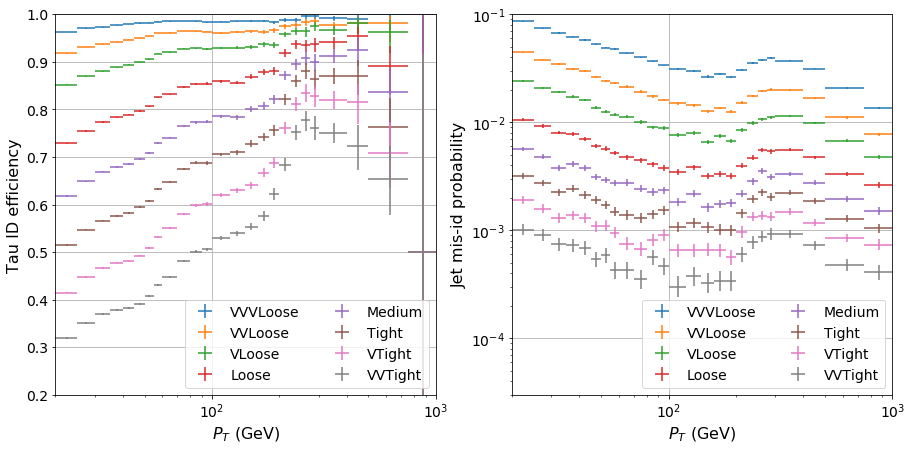

In [377]:
DrawPt(all_df, wp_definitions, 'jet', 'Jet', 'linear', [0.2, 1], [3e-5, 1e-1], 'lower right', 'QCD_jet_pt.pdf')

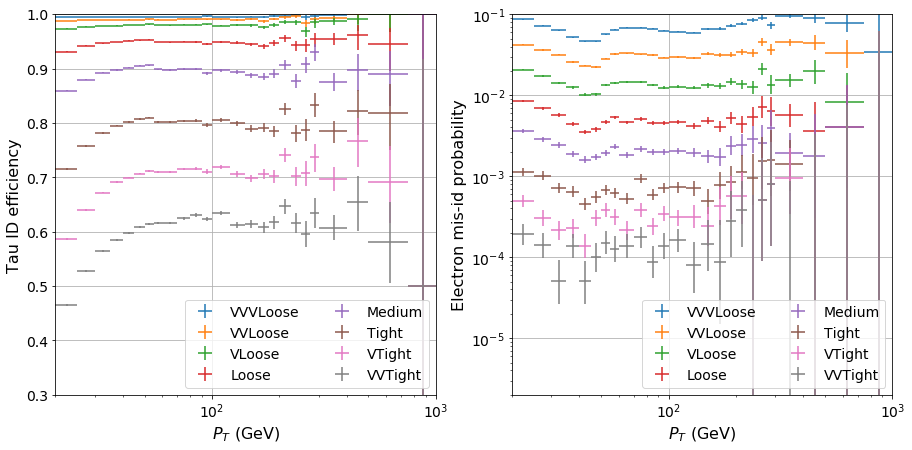

In [380]:
DrawPt(all_df, wp_definitions, 'e', 'Electron', 'linear', [0.3, 1], [2e-6, 1e-1], 'lower right', 'DY_e_pt.pdf')

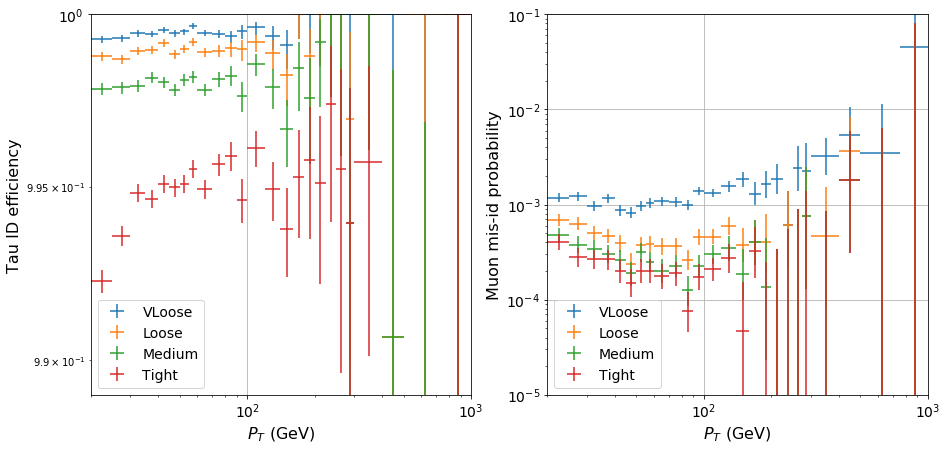

In [441]:
DrawPt(all_df, wp_definitions, 'mu', 'Muon', 'log', [0.989, 1], [1e-5, 1e-1], 'lower left', 'DY_mu_pt.pdf')

In [364]:
def DrawEta(all_df, wp_definitions, other_type, other_name, yscale_1, ylim_1, ylim_2, legend_pos, file_name):
    eta_bins = np.linspace(-2.3, 2.3, 10)
    df_sel = {}
    for tau_type_2 in ['tau', other_type]:
        df = all_df[tau_type_2]
        wp_def = wp_definitions[other_type]
        sel = None
        for tau_type_3 in ['e', 'mu', 'jet']:
            if tau_type_3 == other_type: continue
            wp_def = wp_definitions[tau_type_3]
            thrs = wp_def['thrs']
            if len(thrs) > 0:
                sel_thr = thrs[-1][-1]
                new_sel = (df['deepId_vs_' + tau_type_3] > sel_thr)
                if sel is None:
                    sel = new_sel
                else:
                    sel = sel & new_sel
        df_sel[tau_type_2] = df[sel]

    eff_pt, eff_pt_up, eff_pt_down = diff_efficiency(df_sel['tau'], df_sel[other_type], 'tau_eta', eta_bins,
                                                 np.array(wp_definitions[other_type]['thrs'][-1][::-1]),
                                                 'deepId_vs_' + other_type)
    draw_diff_eff(eff_pt, eff_pt_up, eff_pt_down, eta_bins, np.array(wp_definitions[other_type]['thrs'][-1]),
                  'linear', yscale_1, ylim_1, ylim_2, '$\eta$', 'Tau ID efficiency',
                  other_name + ' mis-id probability', wp_definitions[other_type]['wp_names'][::-1],
                  legend_pos, file_name)

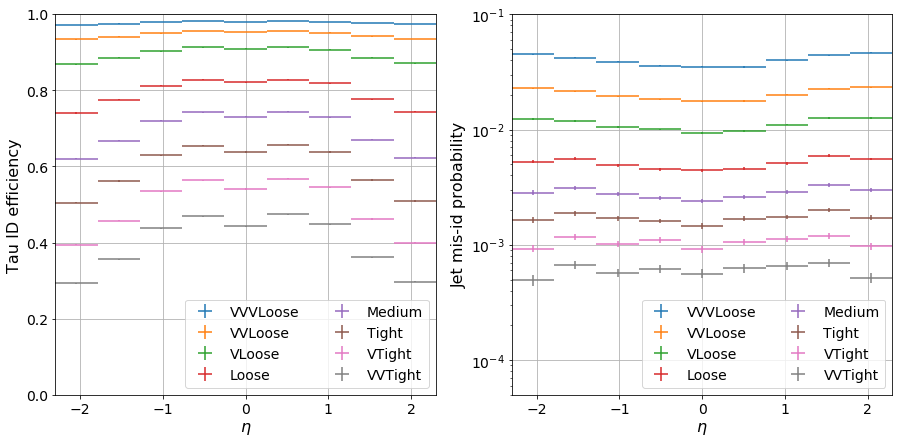

In [389]:
DrawEta(all_df, wp_definitions, 'jet', 'Jet', 'linear', [0, 1], [5e-5, 1e-1], 'lower right', 'QCD_jet_eta.pdf')

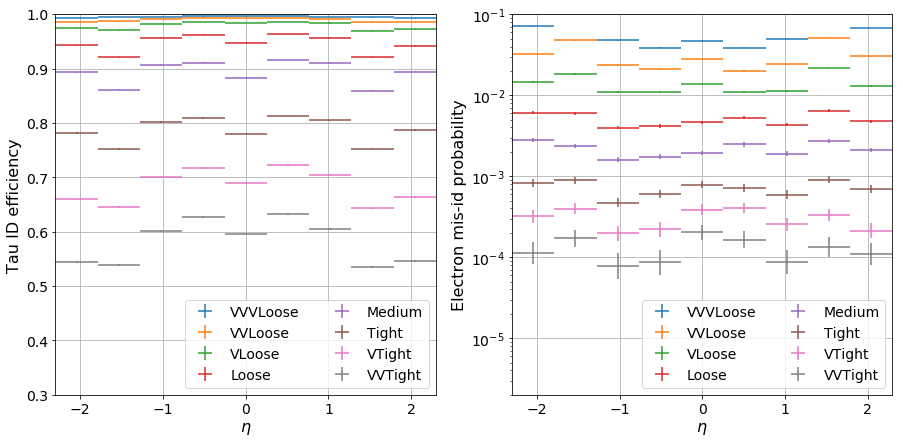

In [390]:
DrawEta(all_df, wp_definitions, 'e', 'Electron', 'linear', [0.3, 1], [2e-6, 1e-1], 'lower right', 'DY_e_eta.pdf')

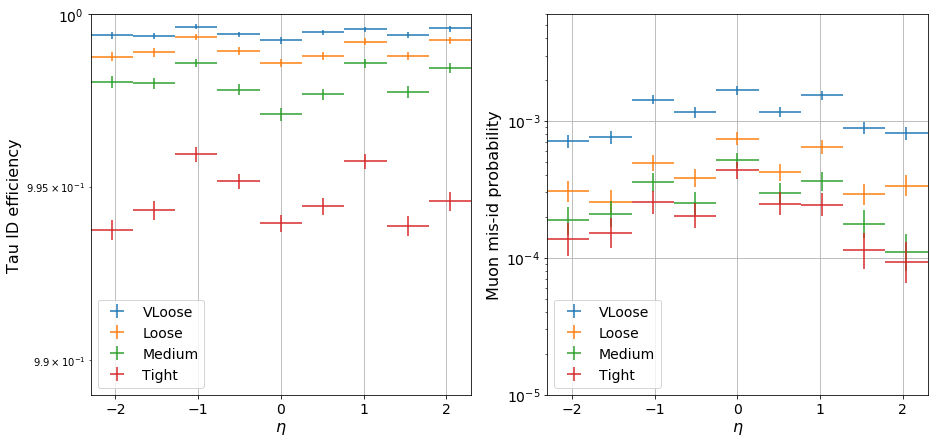

In [391]:
DrawEta(all_df, wp_definitions, 'mu', 'Muon', 'log', [0.989, 1], [1e-5, 6e-3], 'lower left', 'DY_mu_eta.pdf')

In [394]:
def DrawPhi(all_df, wp_definitions, other_type, other_name, yscale_1, ylim_1, ylim_2, legend_pos, file_name):
    phi_bins = np.linspace(-math.pi, math.pi, 10)
    df_sel = {}
    for tau_type_2 in ['tau', other_type]:
        df = all_df[tau_type_2]
        wp_def = wp_definitions[other_type]
        sel = None
        for tau_type_3 in ['e', 'mu', 'jet']:
            if tau_type_3 == other_type: continue
            wp_def = wp_definitions[tau_type_3]
            thrs = wp_def['thrs']
            if len(thrs) > 0:
                sel_thr = thrs[-1][-1]
                new_sel = (df['deepId_vs_' + tau_type_3] > sel_thr)
                if sel is None:
                    sel = new_sel
                else:
                    sel = sel & new_sel
        df_sel[tau_type_2] = df[sel]

    eff_pt, eff_pt_up, eff_pt_down = diff_efficiency(df_sel['tau'], df_sel[other_type], 'tau_phi', phi_bins,
                                                 np.array(wp_definitions[other_type]['thrs'][-1][::-1]),
                                                 'deepId_vs_' + other_type)
    draw_diff_eff(eff_pt, eff_pt_up, eff_pt_down, phi_bins, np.array(wp_definitions[other_type]['thrs'][-1]),
                  'linear', yscale_1, ylim_1, ylim_2, '$\phi$', 'Tau ID efficiency',
                  other_name + ' mis-id probability', wp_definitions[other_type]['wp_names'][::-1],
                  legend_pos, file_name)

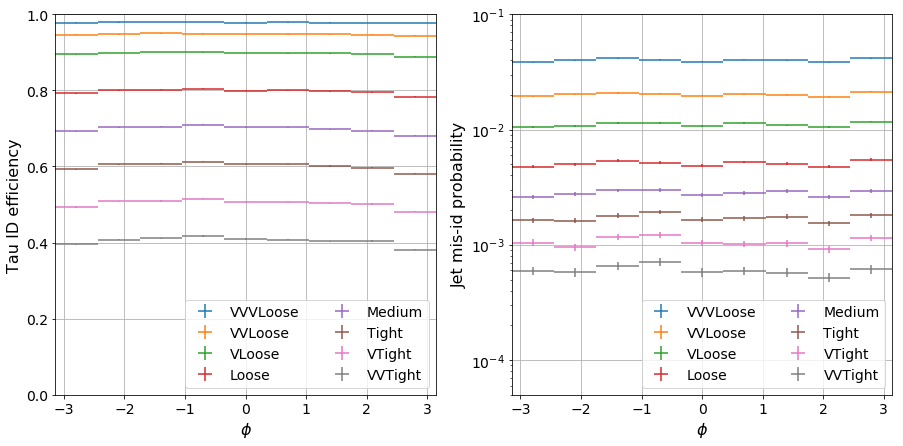

In [395]:
DrawPhi(all_df, wp_definitions, 'jet', 'Jet', 'linear', [0, 1], [5e-5, 1e-1], 'lower right', 'QCD_jet_phi.pdf')

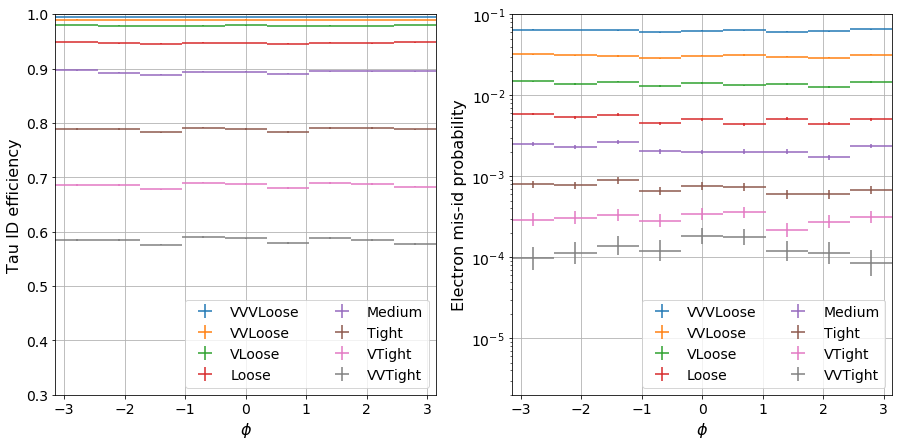

In [396]:
DrawPhi(all_df, wp_definitions, 'e', 'Electron', 'linear', [0.3, 1], [2e-6, 1e-1], 'lower right', 'DY_e_phi.pdf')

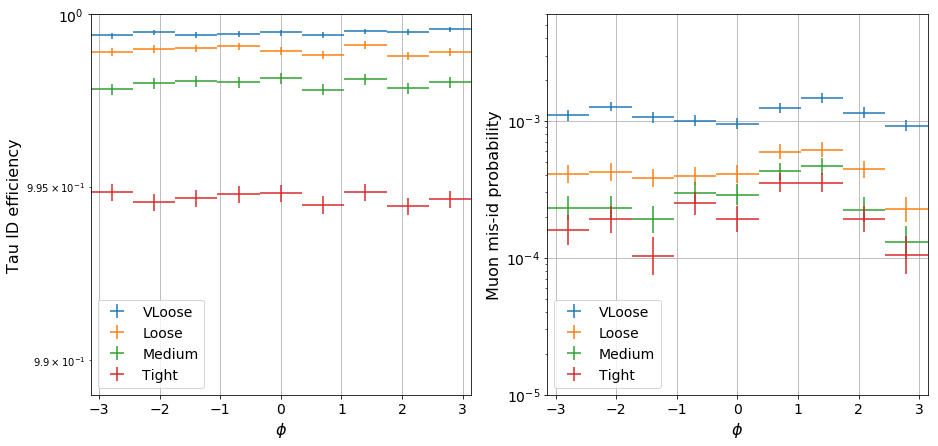

In [397]:
DrawPhi(all_df, wp_definitions, 'mu', 'Muon', 'log', [0.989, 1], [1e-5, 6e-3], 'lower left', 'DY_mu_phi.pdf')

In [417]:
def DrawDM(all_df, wp_definitions, other_type, other_name, yscale_1, ylim_1, ylim_2, legend_pos, file_name):
    dm_bins = np.array([-0.5, 0.5, 1.5, 5.5, 6.5, 10.5, 11.5])
    df_sel = {}
    for tau_type_2 in ['tau', other_type]:
        df = all_df[tau_type_2]
        wp_def = wp_definitions[other_type]
        sel = None
        for tau_type_3 in ['e', 'mu', 'jet']:
            if tau_type_3 == other_type: continue
            wp_def = wp_definitions[tau_type_3]
            thrs = wp_def['thrs']
            if len(thrs) > 0:
                sel_thr = thrs[-1][-1]
                new_sel = (df['deepId_vs_' + tau_type_3] > sel_thr)
                if sel is None:
                    sel = new_sel
                else:
                    sel = sel & new_sel
        df_sel[tau_type_2] = df[sel]

    eff_pt, eff_pt_up, eff_pt_down = diff_efficiency(df_sel['tau'], df_sel[other_type], 'tau_decayMode', dm_bins,
                                                 np.array(wp_definitions[other_type]['thrs'][-1][::-1]),
                                                 'deepId_vs_' + other_type)
    draw_diff_eff(eff_pt, eff_pt_up, eff_pt_down, dm_bins, np.array(wp_definitions[other_type]['thrs'][-1]),
                  'linear', yscale_1, ylim_1, ylim_2, 'decay mode', 'Tau ID efficiency',
                  other_name + ' mis-id probability', wp_definitions[other_type]['wp_names'][::-1],
                  legend_pos, file_name, xlabels=["0", "1", "5", "6", "10", "11"])

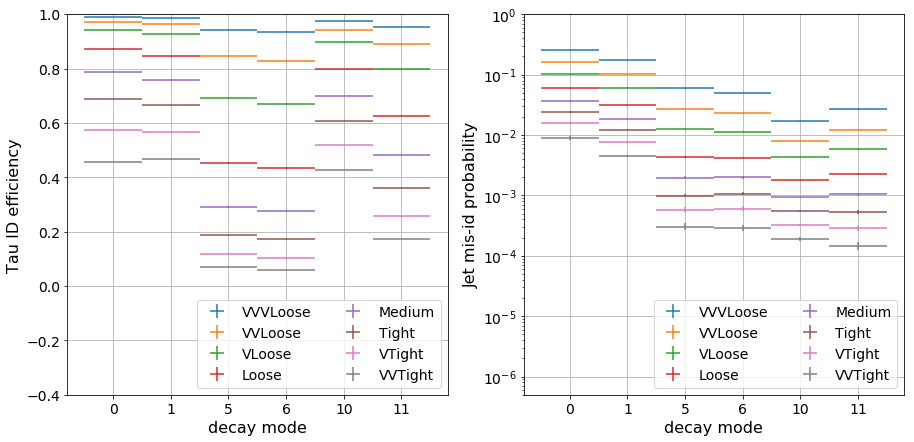

In [431]:
DrawDM(all_df, wp_definitions, 'jet', 'Jet', 'linear', [-0.4, 1], [5e-7, 1], 'lower right', 'QCD_jet_dm.pdf')

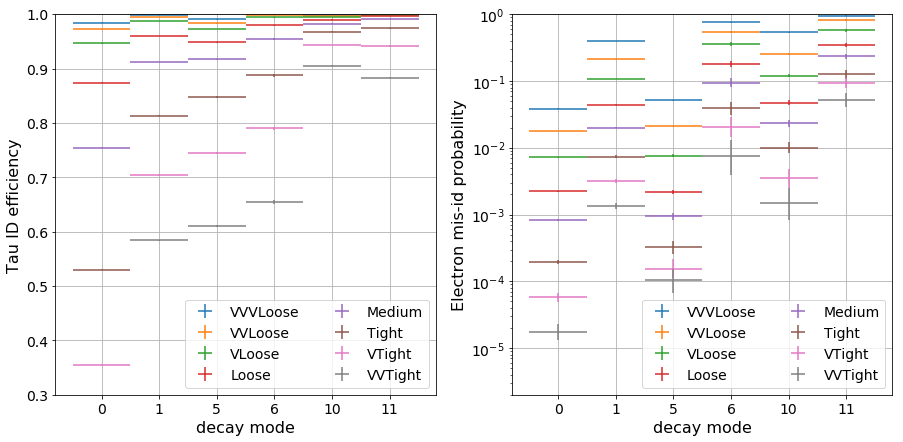

In [432]:
DrawDM(all_df, wp_definitions, 'e', 'Electron', 'linear', [0.3, 1], [2e-6, 1], 'lower right', 'DY_e_dm.pdf')

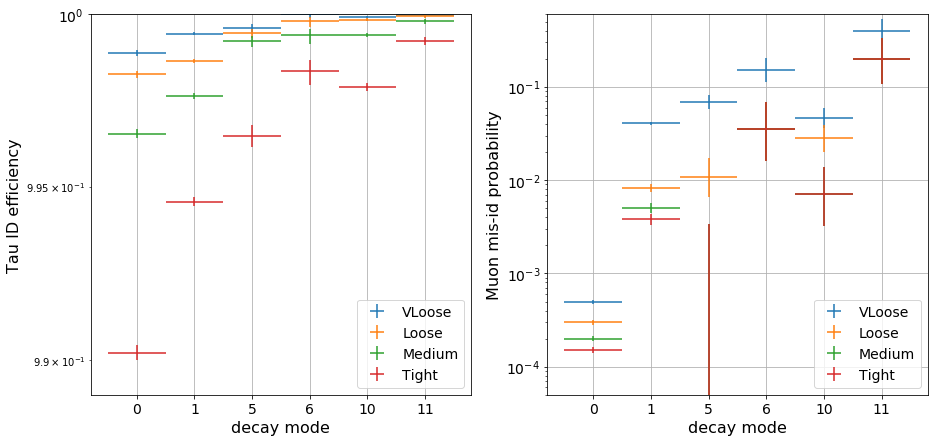

In [439]:
DrawDM(all_df, wp_definitions, 'mu', 'Muon', 'log', [0.989, 1], [5e-5, 6e-1], 'lower right', 'DY_mu_dm.pdf')